# Main Script for a Vocoder

### Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa
try:
    from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler
except:
    !pip install audio-diffusion-pytorch
try: 
    import a_unet
except:
    !pip install a_unet


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler, DiffusionVocoder


# Utils
import numpy as np
from numpy import ndarray
import logging
from typing import Sequence, Optional, Callable


# Base Scripts
from Libraries.Utils import *
from MainScripts.Conf import conf

### Config

### General

In [2]:
remote_kernel: bool = False #Set to true if using a remote Kernel changes the file structure
model_name: str = "vocoder_v1"
training_data_name: str = "training_full_wave"
full_model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)

Logging

In [3]:
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

Training Params

In [4]:
device: str = "cuda" if torch.cuda.is_available() else "cpu"
n_training_samples: int = 5600
n_validation_samples: int = 50
batch_size: int = 48
tensor_dim: list = [batch_size, 1, 512] #B, C, H = Batch, Channels, Time domain

learning_rate: float = 5e-4
epochs: int = 100
restart_training: bool = True
checkpoint_freq: int = 10

### Data Loading

In [5]:
file: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))
data_loader = create_dataloader(Audio_Data(file[:n_training_samples]), batch_size)
validation_dataloader = create_dataloader(Audio_Data(file[-n_validation_samples:]), batch_size)
logger.info(f"Data loaded with shape: {file.shape}")

2025-06-01 17:14:51,090 - INFO - Data loaded with shape: (5888, 147200)


### Setup

Model Creation

In [ ]:
vocoder = DiffusionVocoder(
    mel_n_fft=488,
    mel_channels=224,
    mel_sample_rate=32000,
    mel_normalize_log=True,
    mel_hop_length=288,
    net_t=UNetV0,
    channels=[64, 128, 256, 512, 512, 1024, 1024],
    factors=[1, 2, 2, 2, 2, 2, 2],
    items=[1, 2, 2, 2, 2, 2, 2],
    in_channels=1,
    diffusion_t=VDiffusion,
    sampler_t=VSampler,
).to(device)


c:\Users\finia\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (245) may be set too low.
  warnings.warn(


Model Loading

In [8]:
optimizer = optim.AdamW(vocoder.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
start_epoch: int = 0
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    vocoder.load_state_dict(model["model"])
    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        scheduler.load_state_dict(model["scheduler"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(vocoder)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(vocoder)} Parameters")

2025-06-01 17:15:32,862 - INFO - Model vocoder_v1 created with ~107.6M Parameters


Initiate Trainer

In [ ]:
trainer = Trainer(vocoder, optimizer, scheduler, device)

### Training

2025-06-01 14:03:11,304 - INFO - Training started on cuda
2025-06-01 14:03:30,687 - INFO - Epoch 001: Avg. Loss: 4.81958e-01 Avg. val. Loss: 4.41739e-01 Remaining Time: 00h 31min 58s LR: 4.90000e-04 
2025-06-01 14:03:50,899 - INFO - Epoch 002: Avg. Loss: 3.76561e-01 Avg. val. Loss: 2.48989e-01 Remaining Time: 00h 32min 19s LR: 4.80200e-04 
2025-06-01 14:04:09,195 - INFO - Epoch 003: Avg. Loss: 2.69497e-01 Avg. val. Loss: 1.70749e-01 Remaining Time: 00h 31min 11s LR: 4.70596e-04 
2025-06-01 14:04:27,558 - INFO - Epoch 004: Avg. Loss: 2.00135e-01 Avg. val. Loss: 2.04204e-01 Remaining Time: 00h 30min 29s LR: 4.61184e-04 
2025-06-01 14:04:45,944 - INFO - Epoch 005: Avg. Loss: 1.82818e-01 Avg. val. Loss: 1.25938e-01 Remaining Time: 00h 29min 57s LR: 4.51960e-04 
2025-06-01 14:05:06,163 - INFO - Epoch 006: Avg. Loss: 1.77299e-01 Avg. val. Loss: 1.45474e-01 Remaining Time: 00h 29min 59s LR: 4.42921e-04 
2025-06-01 14:05:27,199 - INFO - Epoch 007: Avg. Loss: 1.72467e-01 Avg. val. Loss: 1.22666

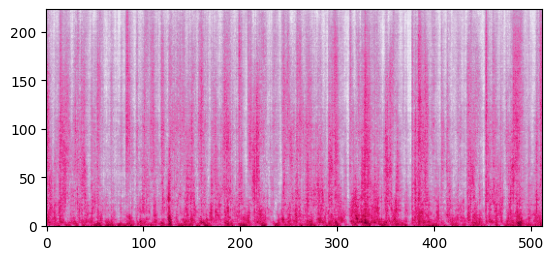

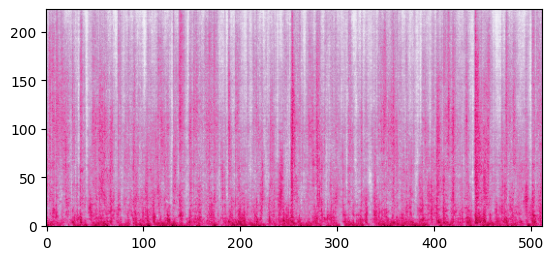

2025-06-01 14:06:31,727 - INFO - Epoch 010: Avg. Loss: 1.68532e-01 Avg. val. Loss: 1.14442e-01 Remaining Time: 00h 30min 03s LR: 4.08536e-04 
2025-06-01 14:07:04,289 - INFO - Epoch 011: Avg. Loss: 1.71086e-01 Avg. val. Loss: 1.44762e-01 Remaining Time: 00h 30min 56s LR: 4.00366e-04 
2025-06-01 14:07:26,318 - INFO - Epoch 012: Avg. Loss: 1.74020e-01 Avg. val. Loss: 2.29938e-01 Remaining Time: 00h 30min 44s LR: 3.92358e-04 
2025-06-01 14:07:47,563 - INFO - Epoch 013: Avg. Loss: 1.66717e-01 Avg. val. Loss: 1.55750e-01 Remaining Time: 00h 30min 25s LR: 3.84511e-04 
2025-06-01 14:08:08,136 - INFO - Epoch 014: Avg. Loss: 1.68321e-01 Avg. val. Loss: 1.38149e-01 Remaining Time: 00h 30min 01s LR: 3.76821e-04 
2025-06-01 14:08:31,525 - INFO - Epoch 015: Avg. Loss: 1.60550e-01 Avg. val. Loss: 1.29354e-01 Remaining Time: 00h 29min 54s LR: 3.69285e-04 
2025-06-01 14:08:52,384 - INFO - Epoch 016: Avg. Loss: 1.66129e-01 Avg. val. Loss: 3.49596e-01 Remaining Time: 00h 29min 32s LR: 3.61899e-04 
2025-0

In [ ]:
train_loss, val_loss = trainer.train(train_dataset=data_loader,
            val_dataset=validation_dataloader,
            n_epochs=epochs,
            full_model_path=full_model_path,
            checkpoint_freq=checkpoint_freq,
            patience=-1,
            gradient_clip_norm=None,
            gradient_clip_val=None,
            sample_freq=10,
            #use_embed=False
            )
scatter_plot(train_loss)
scatter_plot(val_loss)